In [6]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
# enter the foldername in your Drive where you have saved the unzipped
# 'cs231n' folder containing the '.py', 'classifiers' and 'datasets'
# folders.
# e.g. 'cs231n/assignments/assignment1/cs231n/'
FOLDERNAME = 'cs231n/assignments/assignment1/cs231n/'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive/cs231n/assignments/assignment1/cs231n/datasets
!bash get_datasets.sh
%cd ../../

/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment1


In [ ]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   4488      0 --:--:-- --:--:-- --:--:--  4488
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 339.6MB 53kB/s 
+ set +ex
Installation succeeded!


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [8]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [9]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

In [16]:
import matplotlib
A = np.array([[1,2,3],[4,5]])
B = np.hstack(A)
print(B.T)

[1 2 3 4 5]


## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [10]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [29]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = np.linspace(8e-7,2e-6,10)
regularization_strengths = np.linspace(1e4,1e5,10)
batch_sizes = [500,1000]

results = {}
best_val = -1
best_svm = None
losses = []
best_loss = None
best_paras = []

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
  for reg in regularization_strengths:
    for batch_size in batch_sizes:
      svm = LinearSVM()
      loss_history = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=200,batch_size=batch_size)
      losses.append(loss_history)
      train_predict = svm.predict(X_train_feats)
      train_acc = np.mean(train_predict == y_train)
      val_predict = svm.predict(X_val_feats)
      val_acc = np.mean(val_predict == y_val)
      results[(lr,reg)] = (train_acc,val_acc)
      print('lr %e reg %e batch size %d train accuracy: %f val accuracy: %f' % (lr, reg, batch_size, train_acc, val_acc))
      if val_acc > best_val:
        best_val = val_acc
        best_svm = svm
        best_loss = loss_history
        best_paras = [lr,reg,batch_size]

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
# for lr, reg in sorted(results):
#     train_accuracy, val_accuracy = results[(lr, reg)]
#     print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
#                 lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: {} \nbest parameters {}'.format(best_val, best_paras))

lr 8.000000e-07 reg 1.000000e+04 batch size 500 train accuracy: 0.232776 val accuracy: 0.255000
lr 8.000000e-07 reg 1.000000e+04 batch size 1000 train accuracy: 0.220714 val accuracy: 0.226000
lr 8.000000e-07 reg 2.000000e+04 batch size 500 train accuracy: 0.411898 val accuracy: 0.414000
lr 8.000000e-07 reg 2.000000e+04 batch size 1000 train accuracy: 0.407408 val accuracy: 0.406000
lr 8.000000e-07 reg 3.000000e+04 batch size 500 train accuracy: 0.411918 val accuracy: 0.412000
lr 8.000000e-07 reg 3.000000e+04 batch size 1000 train accuracy: 0.413878 val accuracy: 0.428000
lr 8.000000e-07 reg 4.000000e+04 batch size 500 train accuracy: 0.417245 val accuracy: 0.420000
lr 8.000000e-07 reg 4.000000e+04 batch size 1000 train accuracy: 0.414959 val accuracy: 0.421000
lr 8.000000e-07 reg 5.000000e+04 batch size 500 train accuracy: 0.415551 val accuracy: 0.422000
lr 8.000000e-07 reg 5.000000e+04 batch size 1000 train accuracy: 0.417327 val accuracy: 0.414000
lr 8.000000e-07 reg 6.000000e+04 ba

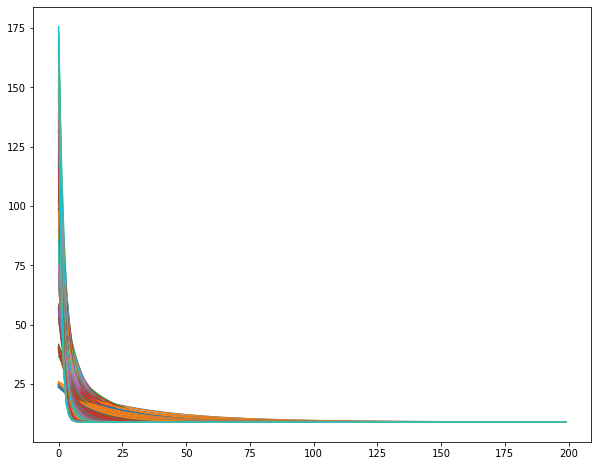

In [30]:
#Show the loss decreasing trend
for loss in losses:
  plt.plot(loss)
plt.show()
#This trend shows that the loss decrese quickly, therefore, a iteration number of 200 is enough.
#This can accelerate the training process

In [31]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.425


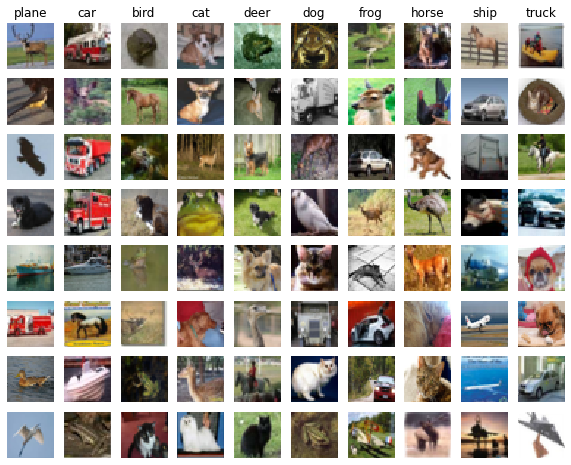

In [39]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$ If we look at the column of plane, we can find that the objects are always surrounded by some kind of blue. And this is what our hue feature want to extract.




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [40]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


lr 0.8, hidden size 500, regularization strength 0.001, batch_size 1000, train acc 0.6611224489795918, val acc 0.596
lr 0.8, hidden size 500, regularization strength 0.002, batch_size 1000, train acc 0.6354081632653061, val acc 0.577
lr 0.8, hidden size 500, regularization strength 0.003, batch_size 1000, train acc 0.6139183673469387, val acc 0.577
lr 0.8, hidden size 500, regularization strength 0.004, batch_size 1000, train acc 0.5946938775510204, val acc 0.571
lr 0.8, hidden size 500, regularization strength 0.005, batch_size 1000, train acc 0.5769591836734694, val acc 0.545
lr 0.8, hidden size 1000, regularization strength 0.001, batch_size 1000, train acc 0.6714081632653062, val acc 0.605
lr 0.8, hidden size 1000, regularization strength 0.002, batch_size 1000, train acc 0.6400816326530612, val acc 0.596
lr 0.8, hidden size 1000, regularization strength 0.003, batch_size 1000, train acc 0.6160204081632653, val acc 0.589
lr 0.8, hidden size 1000, regularization strength 0.004, batc

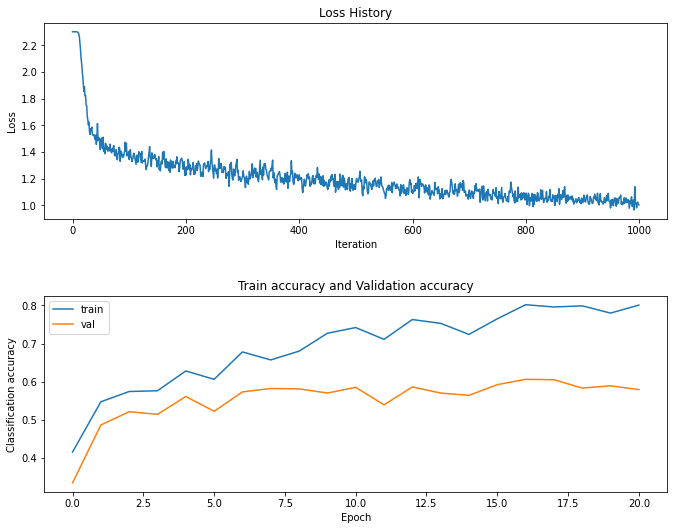

In [73]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = np.linspace(500,1000,2).astype(int)
learning_rates = np.linspace(8e-1,2e0,10)
regularization_strengths = np.linspace(1e-3,5e-3,5)
batch_sizes = [1000]
num_classes = 10

best_net = None
best_stats = None
best_acc = 0
best_paras = None
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
  for hidden_size in hidden_dim:
    for rs in regularization_strengths:
      for batch_size in batch_sizes:
        net = TwoLayerNet(input_dim, hidden_size, num_classes)

        #train the network
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=1000, batch_size=batch_size,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=rs, verbose=False)
        y_train_predict = net.predict(X_train_feats)
        train_acc = np.mean(y_train_predict == y_train)
        y_val_predict = net.predict(X_val_feats)
        val_acc = np.mean(y_val_predict == y_val)
        if val_acc > best_acc:
          best_acc = val_acc
          best_net = net
          best_stats = stats
          best_paras = [lr,hidden_size,rs,batch_size]
        print('lr {}, hidden size {}, regularization strength {}, batch_size {}, train acc {}, val acc {}'.format(lr,hidden_size,rs,batch_size,train_acc,val_acc))

print('best validation accuracy achieved during cross-validation: {} \nbest parameters {}'.format(best_acc, best_paras))

#plot result
plt.subplot(2,1,1)
plt.plot(best_stats['loss_history'])
plt.title('Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2,1,2)
plt.plot(best_stats['train_acc_history'],label='train')
plt.plot(best_stats['val_acc_history'],label='val')
plt.title('Train accuracy and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.tight_layout(pad=3)
plt.show()
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

In [74]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.595


---
# IMPORTANT

This is the end of this question. Please do the following:

1. Click `File -> Save` to make sure the latest checkpoint of this notebook is saved to your Drive.
2. Execute the cell below to download the modified `.py` files back to your drive.

In [ ]:
import os

FOLDER_TO_SAVE = os.path.join('drive/My Drive/', FOLDERNAME)
FILES_TO_SAVE = []

for files in FILES_TO_SAVE:
  with open(os.path.join(FOLDER_TO_SAVE, '/'.join(files.split('/')[1:])), 'w') as f:
    f.write(''.join(open(files).readlines()))